##### Copyright 2020 The Cirq Developers

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum walk

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/quantum_walks"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/quantum_walks.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/quantum_walks.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/quantum_walks.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [ ]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

The goal of this Notebook is to provide an interesting exposition to simulating quantum computational processes with Cirq. We will be investigating a very fundamental and interesting idea within quantum computing called the **quantum walk**, starting off with some information on classical random walks, and then building upon that knowledge to understand exactly what a quantum walk is, all while simulating the processes that are outlined mathematically with Cirq. 

In order to get started, we first need to import these libraries:

In [ ]:
import cirq
import random
import numpy as np
from matplotlib import pyplot as plt
import scipy

First, we'll need `cirq`. The `random` library is used to simulate our classical random walk, `matplotlib` is used to create graphs, and `numpy` and `scipy` are used for processing vectors, matrices, and more.

Before we get started with quantum walks, let's first look into it's classical counterpart, and understand what a "walk" truly is:

## Classical random walks

A random walk is a random process involving a "walker" that is placed in some $n$-dimensional medium, like a grid or a graph. 
We then repeatedly query some random variable, and based on the outcome of our measurement,
the walker's position vector (position on the graph or grid) is updated. A basic example of a random walk is 
the one-dimensional graphical case, where we consider a marker placed on the origin of a number line with markings
at each of the integers. Let the initial position vector of our marker be $\lvert 0\rangle$. For $N$ steps of our
random walk, take a set of $N$ random variables $\{X_1, \ ..., \ X_N\}$, which can take on either a value of 
$1$ or $-1$ with equal probability. To find the updated position vector of our walker, we compute
the value:

$$j \ = \ \displaystyle\sum_{k \ = \ 1}^{N} \ X_k$$

Where we know:


$$\lvert \text{Final}\rangle \ = \ \lvert \text{Initial} \ + \ j\rangle$$


So for our case, the final position vector is $\lvert j\rangle$. This model of a random walk can 
be generalized to $n$-dimensions. 


Another important fact to note is that for a discrete, 1-dimensional random 
walk on a number-line-like graph, the probability of the random walker being at a specific location follows 
a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Let us define an $N$-step random walk. Let us then assert that $N \ = \ L \ + \ R$, 
where $L$ is the number of steps to the left, and $R$ is the number of steps to the right. We can then reason 
that if there is some probability $p_{r}$ of the walker taking a rightward step at one time-step of the random 
walk, the probability of taking a leftward step is given by $1 \ - \ p_{r}$. It follows that the probability 
of taking $L \ = \ N \ - \ R$ leftward steps, and $R$ rightward steps in a random walk of $N$ total steps is:


$$P(N, \ R) \ = \ p_{r}^R (1 \ - \ p_{r})^{N \ - \ R}$$

We then have to consider the probability that for an $N$ step random walk, our walker ends up at position 
$X \ = \ R \ - \ L$. Well, we know the probability of taking $L$ left steps and $R$ right steps, and we know 
that for a random walk of $N$ steps, the position of the walker is determined by the number of right steps, 
minus the number of left steps. Since it doesn't matter the order in which the sequence of $N$ steps occurs, 
to find the total probability of being at some location, $P(X)$, we have to multiply the probability $P(L, \ R)$ 
by the number of possible ways in which $L$ left steps and $R$ right steps can be arranged in a sequence. 
Well, since we have $N$ total steps, we can "choose" $R$ of those steps to be allocated to rightward steps, 
and automatically know that the remaining $N \ - \ R$ steps were left steps. We calculate $N$ "choose" $R$ 
steps by calculating the binomial coefficient, therefore getting:


$$P_{N}(X) \ = \ \begin{pmatrix} N \\ R \end{pmatrix} \ p_{r}^R (1 \ - \ p_{r})^{N \ - \ R} \Rightarrow \ X \ = \ R \ - \ L \ \Rightarrow \ P_{N}(X) \ = \ \begin{pmatrix} N \\ \frac{N \ + \ X}{2} \end{pmatrix} \ p_{r}^{\frac{N \ + \ X}{2}} (1 \ - \ p_{r})^{\frac{N \ - \ X}{2}}$$

It is important to note that this only holds true for **even numbers** if the total number of steps taken is even, and **odd numbers** if the total number of steps taken is odd. This is due to the fact that if we set the number of steps that the random walk can take to $N$, then as we previously demonstrated, $L \ + \ R \ = \ N$ and $R \ - \ L \ = \ X$. Combining these two equations, we get, just like in the equation above:

$$R \ = \ \frac{X \ + \ N}{2}$$

But $R$ must be an integer, thus $X \ + \ N$. Must be even. It follows that if $N$ is odd, then $X$ must also be odd to make an even number, and if $N$ is even, $X$ must also be even. From this, we come to the conclusion that if we have an even $N$, the probability of being at a position $X$ that is an odd value is $0$, and if $N$ is odd, then the probability of $X$ being even is $0$.

And so we have shown that the probability distribution for the position of the walker for an $N$ step random 
walk is given by a binomial distribution on the domain of the even or the odd numbers. This fact is important, as we will show that the probability distribution that is created when a quantum walk is simulated is nowhere close to the binomial distribution that we expect to see for a classical 1-dimensional random walk.

If you don't believe me and/or the math, we can visualize this a bit better by coding up a simple program! We will define a one-dimensional random walk, starting at the point $0$ on the integer number line. We will then repeatedly "flip a coin", and move left and right down the number line accordingly: 

In [ ]:
# Defines all of the necessary parameters

N = 50    # Defines the total number of steps our walker will take
pr = 0.5  # Defines the probability of our walker stepping to the right
i = 0     # Defines the initial position of our walker

def random_walk(pr, N, i):
    
    position = i
    
    # Repeatedly queries our random variable and moves our walker for the specified number of steps
    
    for j in range(0, N): 
    
        coin_flip = list(np.random.choice(2, 1, p=[1-pr, pr])) # Flips our weighted coin
        position += 2*coin_flip[0]-1 # Moves our walker according to the coin flip 
    
    return position
    
print("The walker is located at: x = {var}".format(var = random_walk(pr, N, i)))

The walker is located at: x = -6


Now, let's attempt to generate the probability distribution corresponding to the walker's position, and make sure that it checks out with our math:

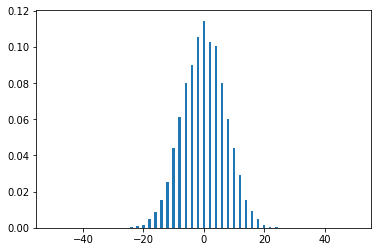

In [ ]:
def dist(runs, N):
    
    positions = range(-1*N, N+1)
    instances = [0 for i in range(-1*N, N+1)]
    
    for k in range(0, runs):

        result = random_walk(pr, N, i)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n/runs for n in instances])
    plt.show()
    
dist(10000, N)

That looks pretty binomial to me (which is exactly what the math predicts)! We can now plot the distribution predicted in the math, and see if the two are the same:

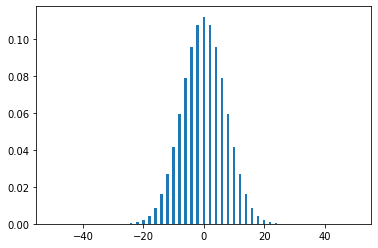

In [ ]:
def height_calculate(x, N, pr):
    
    a = (N + x)/2
    b = (N - x)/2
    
    if (x%2 == 0):
        var = scipy.special.binom(N, a)*(pr**a)*((1-pr)**b)
    else:
        var = 0
    return var

positions = range(-1*N, N+1)
heights = [height_calculate(x, N, pr) for x in positions]
plt.bar(positions, heights)
plt.show()

As you can see, the distributions look very similar, with the midpoint having a probability of a little bit over $0.1$ in both graphs. Note that as we increase the `runs` variable, our simulated distribution will resemble our theoretical distribution more and more, as one would expect:

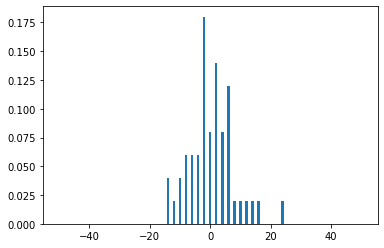

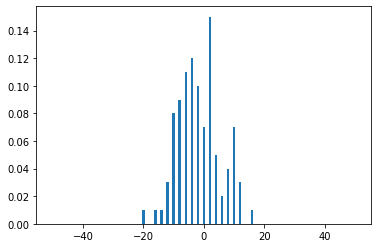

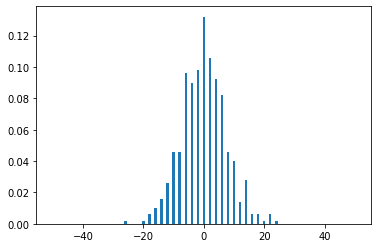

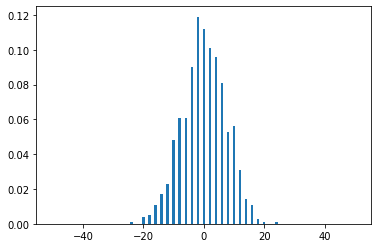

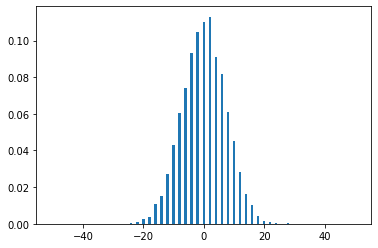

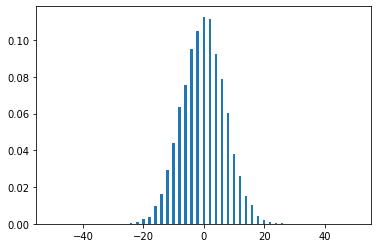

In [ ]:
run_range = [50, 100, 500, 1000, 5000, 10000]
for run in run_range:
    dist(run, N)

## Quantum walks

The process of the quantum walk isn't that much different from its classical counterpart, although 
the observed results of the two processes have many differences. First, let us motivate the creation of a 
QW. The idea is that when one performs analysis on a classical random walk, you can find that 
$\sigma^2 \ \sim \ T$, where $\sigma$ is the standard deviation of the random walk's probability distribution, 
and $T$ is the number of time-steps of the random walk. For the quantum walk, we can see that 
$\sigma^2 \ \sim \ T^2$. In other words, the standard deviation grows at a quadratically faster rate. 
At a high level, this signifies that the quantum walker "spreads out" quadratically faster than the 
classical one, showing that the process of a QW is quadratically faster than its classical counterpart.


In order to create a quantum walk, we have to translate the components of the classical random walk 
to a quantum problem. We can encode the position of a "walker" in some $n$ -dimensional space with a vector
$\lvert j\rangle$. For the purpose of this project, we will be investigating a basic case of a 
random walk on a ring-shaped graph, with adjacent nodes connected by a single edge. The configuration 
looks something like this:


<img src="../images/cycle.png" style="width:550px;height:500px;">


Going back to our original idea of some position vector $\lvert j\rangle$, it is apparent that in order to 
encode the location of a "walker" on this graph, we need to assign a specific value of our position vector 
to each node. Well, this is fairly simple, for a graph of $K$ nodes, we form a Hilbert space
$H_W$ spanned by the following set:


$$H_W \ = \ \{\lvert j\rangle \ : \ j \ = \ 0, \ ..., \ K \ - \ 1 \}$$


We also require another vector in order to create a random walk. We need a "coin vector", which will encode 
the direction in which the random walk will progress at the $T$-th step of the process. This Hilbert space 
is spanned by the two basis states, representing forward and backward progression on our number-line-like 
graph (actually, our graph looks more like a ring, so the two basis states will represent 
clockwise and counter-clockwise motion, but it's the same idea). We will call this Hilbert space $H_C$, 
and we can again define our spanning set:


$$H_C \ = \ \{\lvert i\rangle \ : \ i \ = \ \downarrow, \ \uparrow\rangle\}$$


Where the upward-arrow symbol represent counter-clockwise motion, and the downward arrow represents 
clock-wise motion. Now that we have defined all of the vectors we need to encode the information about 
our random walk, we must understand how we can realize these vectors in our quantum algorithm. Well, this is 
again fairly simple. For a graph of $K \ = \ 2^n$ nodes, we require $n$ qubits to encode binary representations 
of numbers ranging from $0$ to $K \ - \ 1$, therefore each of the vectors spanning $H_W$ will be given 
by the binary representation of $j$ corresponding to the basis vector $\lvert j\rangle$. For the coin vector, 
since we have only two states, we only need one qubit to encode the two possible states:


$$\lvert 0\rangle \ = \ \lvert \uparrow\rangle \ \ \text{and} \ \ \lvert 1\rangle \ = \ \lvert \downarrow\rangle$$


In order to represent the total space of all possible states of our system, we take the tensor product of the 
two spanning sets, which will then span the new Hilbert space $H_C \ \otimes \ H_W$. We will write a general 
element of this Hilbert space as $\lvert i\rangle \ \otimes \ \lvert j\rangle$.

Moving right along, we now require a method to evolve our walk forward at each step. We define a random 
walk evolution operator as follows:


$$U \ = \ \lvert \uparrow\rangle\langle\uparrow\lvert  \ \otimes \ \displaystyle\sum_{j} \ \lvert j \ + \ 1\rangle\langle j\lvert  \ + \ \lvert \downarrow\rangle\langle\downarrow\lvert  \ \otimes \ \displaystyle\sum_{j} \ \lvert j \ - \ 1\rangle\langle j\lvert $$


Essentially, since our qubits take on states $\lvert 0\rangle$ and $\lvert 1\rangle$, we know that 
any possible, general basis state vector formed from qubits $\lvert n\rangle^{\otimes \ N}$ will be orthogonal to 
all other vectors in the basis spanning the space. Because of this, we can create an operator that first 
"picks out" the coin vector's state (the other term just goes to $0$, as, like I said, the states or orthogonal), 
and then sums over all possible position states until it finds the position state to which the operator is 
being applied. The inner product of the vector and itself is just one (the vectors are not only orthogonal, 
they're orthonormal!), and the new position state of the vector is $\lvert j \ \pm \ 1\rangle$, depending on 
the state of the coin vector. This did exactly what we wanted, it evolved our walk either forward or 
backwards by one step! If you're still not convinced, let's check to see what happens when we have the state 
$\lvert \uparrow\rangle \ \otimes \ \lvert 1\rangle$ and we apply the $U$ operator:


  $$U (\lvert \uparrow\rangle \ \otimes \ \lvert 1\rangle) \  \ = \ \Big( \ \lvert \uparrow\rangle\langle\uparrow\lvert  \ \otimes \ \displaystyle\sum_{j} \ \lvert j \ + \ 1\rangle\langle j\lvert  \ + \ \lvert \downarrow\rangle\langle\downarrow\lvert  \ \otimes \ \displaystyle\sum_{j} \ \lvert j \ - \ 1\rangle\langle j\lvert  \Big )(\lvert \uparrow\rangle \ \otimes \ \lvert 1\rangle)$$
  
  $$\Rightarrow \ \lvert \uparrow\rangle\langle\uparrow\lvert  \uparrow\rangle \ \otimes \ \displaystyle\sum_{j} \ \lvert j \ + \ 1\rangle\langle j\lvert  1\rangle \ + \ \lvert \downarrow\rangle\langle\downarrow\lvert  \uparrow\rangle \ \otimes \ \displaystyle\sum_{j} \ \lvert j \ - \ 1\rangle\langle j\lvert  1\rangle$$


  $$\Rightarrow \ \lvert \uparrow\rangle \ \otimes \ \lvert 2\rangle \ + \ 0\lvert \downarrow\rangle \ \otimes \ \lvert 0\rangle \ = \ \lvert \uparrow\rangle \ \otimes \ \lvert 2\rangle$$


  As you can see, it works! Now, we must consider the randomness of the classical random walk. For the purposes of our 
  quantum walk, we will "set" $p_{r} \ = \ 0.5$, and therefore make $p_{l} \ = \ 0.5$ as well. At each time step, 
  it is necessary that we randomly flip the state of our coin vector $\lvert i\rangle$. The Hadamard 
  transformation seems like a natural choice, as:


  $$H \ = \ \frac{1}{\sqrt{2}}\begin{pmatrix} 1 && 1 \\ 1 && -1 \end{pmatrix} \ \Rightarrow \ H \lvert  \uparrow\rangle \ = \ \frac{\lvert  \uparrow\rangle  \ + \ \lvert  \downarrow\rangle }{\sqrt{2}} \ \Rightarrow \ H \lvert  \downarrow\rangle \ = \ \frac{\lvert  \uparrow\rangle  \ - \ \lvert  \downarrow\rangle }{\sqrt{2}}$$


  The probability of measuring one of the basis states is given by squaring the coefficient in the linear combination, which we can see for both outcomes is equal to $0.5$, the same probability of a step to the 
  right/step to the left that we originally desired. We can now combine our operators into one "master operator" 
  that works as one complete step of the random walk, including randomizing the coin vector:


  $$S \ = \ U \ (H \ \otimes \ I)$$

## Build a quantum walk with Cirq

Now, that we have established all of the necessary mathematical rigour to create a quantum walk, we 
need to translate this into code. We can start by creating a qubit register, which will be used to represent 
all of the position vectors on our graph. Recall that for an $N$ qubit register, we can encode all numbers 
ranging from $0$ to $2^N \ - \ 1$. For now, we will set $N \ = \ 7$:

In [ ]:
number_qubits = 7
qubits = cirq.GridQubit.rect(1, number_qubits)

print(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4), cirq.GridQubit(0, 5), cirq.GridQubit(0, 6)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4), cirq.GridQubit(0, 5), cirq.GridQubit(0, 6)]


Next, we have to initialize our qubit register into some initial state. This can vary quite a bit, depending on 
the simulation that we want to make. To start, let's say that our initial position vector for our "walker" 
is roughly in the middle of the graph (not exactly, as we have an even number of position vector values). Let's 
also say that our coin vector is initialized in the $|\downarrow\rangle$ state. Since $|\downarrow\rangle$ corresponds to $|1\rangle$, the only operations that have to be performed in this qubit initialization method is 
an $X$ gate acting on ``GridQubit(0, 1)`` (initializing the position vector), as well as an $X$ gate acting on 
the coin qubit:

In [ ]:
def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))
    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

Now that we have created and initialized our qubit register, we have to create an operation that can evolve 
our walk forward by one step. At a high level, our evolution operation will follow this process:

1. "Flip" the coin qubit. The result of this "flip" will tell us in which direction our random walker should move. This "flip" operation is nothing more than a Hadamard transformation applied to the coin qubit after each evolution operation.


2. Based on the state of the coin qubit after the flip, either perform the operation $|j\rangle \ \rightarrow \ |j \ + \ 1\rangle$ or $|j\rangle \ \rightarrow \ |j \ - \ 1\rangle$ on the register of qubits encoding the position vector of the walker on the graph. This will involve having two operations controlled by opposite states of the coin quibt, each representing a step forward or a step backward on the graph. Thus, our evolution operation will look something like this:

<img src="../images/circ2.png" style="width:400px;height:170px;margin-left:25%">


If we construct our evolution operator in this fashion, the coin qubit is able to dictate whether the walker 
steps forwards or backwards without ever having to be measured!


Now that we have a high-level setup for our evolution operator, we have to construct the "step forward" and 
"step backward" operations. These are nothing more than an addition and a subtraction operator, each of with 
adds or subtracts $1$ from the position vector. 


Before we actually dive into making the addition and subtraction operators, it will be useful for us to define 
an operation which we will call an <i>n-qubit Toffoli gate</i>. The name is pretty self-explanatory, it is just 
an $X$ gate that is controlled by an arbitrary number of qubits $n$, rather than only $1$ or $2$ in the 
standard $CNOT$ and Toffoli gates. In order to implement this, we can use the built-in function Cirq: `cirq.X(target).controlled_by(*controls)` (see Appendix A for an exact implementation of this gate with $CNOT$s).

Now we can get back to creating the addition and substraction operators. Starting with the addition operator, 
the idea is:



1. Have a $CNOT$ gate controlled by the coin qubit targetting the least significant qubit. This means that if the coin qubit is in the "move forward" state, the addition operator will be activated.


2. Apply an $X$ gate to the qubit that was just targetted by the $CNOT$ gate.


3. Apply a Toffoli gate controlled by the coin qubit and the qubit on which the $X$ gate was just placed, targetting the second least-significant qubit. This acts as a "carry operation", meaning that if the coin qubit is in the addition state, and the least significant qubit is in the $|0\rangle$ state (meaning it was in the $|1\rangle$ state, but had the $CNOT$ operation applied to it, we had to apply the $X$ gate to flip it back to the $|1\rangle$ state so it can activate the Toffoli gate), then flip the value of the next qubit, signifying that the addition mod $2$ carried over a one to the next digit of the number.


4. Continue this process with $n$-qubit Toffoli gates controlled by all qubits less significant than the target qubit, along with the coin qubit until all qubits have had Toffoli gates applied.


5. Apply $X$ gates to all qubits in the position vector register, as they all had $X$ gates applied to them in the process of addition (This jusst cancels out when we apply the inverse operator to perform subtraction).

For the subtraction operator, we can make use of the fact that quantum operations are reversible, meaning that if 
we have some addition unitary $A$, such that $A |j\rangle \ = \ |j \ + \ 1\rangle$, then:


$$A^{\dagger}A |j\rangle \ = \ A^{\dagger}|j \ + \ 1\rangle \ \Rightarrow \ A^{\dagger}|j \ + \ 1\rangle \ = \ |j\rangle \ \Rightarrow \ A^{\dagger}|k\rangle \ = \ |k \ - \ 1\rangle$$


And so this means that $S \ = \ A^{\dagger}$. Since we can decompose $A$ into a product of a bunch of unitaries, 
we get:


 $$A \ = \ U_1 U_2 \ ... \ U_n \ \Rightarrow \ S \ = \ A^{\dagger} \ = \ U_n^{\dagger} U_{n - 1}^{\dagger} \ ... \ U_{1}^{\dagger}$$


But our method only uses $X$ gates and controlled $X$ gates, all of which are Hermitian, thus we have:


$$S \ = \ U_n^{\dagger} U_{n - 1}^{\dagger} \ ... \ U_{1}^{\dagger} \ = \ U_n U_{n - 1} \ ... \ U_{1}$$


So basically, our subtraction operation will just be applying our addition operator, but with the order of 
gates reversed. This allows us to create one general "evolution operation" for our walk, which adds 
or substract $1$ to the walker's position vector, based on the coin qubit:

In [ ]:
def walk_step():

    # "Flip" the coin vector

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))

    # Implement the Addition Operator

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits, 0, -1):
        
        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i-1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i-1)).controlled_by(*controls)
        if (i > 1):
            yield cirq.X.on(cirq.GridQubit(0, i-1))

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    # Implement the Substraction Operator

    for i in range(1, number_qubits+1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i-1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i-1)).controlled_by(*controls)
        if (i < number_qubits):
            yield cirq.X.on(cirq.GridQubit(0, i))

Next, we have to append these operations to our quantum circuit, specifically iteratively apply the 
``walk_step()`` function in order to evolve our random walk forward. After we do this, we measure of position 
vector qubit register, by applying measurement gates, and we sample our circuit repeatedly. In code, for the 
example of $10$ iteration of our evolution operator, $200$ samples of the circuit, and $7$ position vector 
qubits, we have:

In [ ]:
number_qubits = 7
iterator = 30
sample_number = 5000

def generate_walk(number_qubits, iterator, sample_number):

    circuit = cirq.Circuit()

    circuit.append(initial_state())
    for j in range(0, iterator):
        circuit.append(walk_step())
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=sample_number)
    final = result.histogram(key='x')

    print(final)
    return final

final = generate_walk(number_qubits, iterator, sample_number)

Counter({12: 1217, 14: 642, 20: 332, 10: 329, 52: 277, 16: 263, 18: 219, 48: 182, 22: 164, 54: 123, 42: 121, 32: 117, 26: 115, 30: 114, 40: 109, 28: 107, 36: 103, 38: 101, 24: 98, 34: 83, 44: 60, 46: 55, 50: 27, 8: 26, 56: 15, 58: 1})


Finally, we then graph the results of our simulation, with final position vector value on the x-axis and the 
number of occurrences of that position vector value on the y-axis. This gives us a probability distribution for 
the position of the walker. It is important to note that the graphs will only have either even or odd 
numbered data point, depending on the initial position of the walker and the number of steps taken:

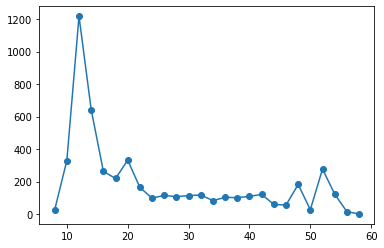

In [ ]:
def graph(final):

    x_arr = list(final.keys())
    y_arr = [dict(final)[j] for j in dict(final).keys()]

    x_arr_final = []
    y_arr_final = []

    while (len(x_arr) > 0):

        x_arr_final.append(min(x_arr))
        y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
        holder = x_arr.index(min(x_arr))
        del x_arr[holder]
        del y_arr[holder]

    plt.plot(x_arr_final, y_arr_final)
    plt.scatter(x_arr_final, y_arr_final)
    plt.show()

graph(final)

As you can see, we get a pretty strange probability distribution! This is due to the fact that repeated 
applications of the Hadamard gate to the coin qubit (which you may recall was initialized in the $|\downarrow\rangle$ state). Over time, interference causes our coin qubit to bias to the left, but also creates a small bump far to 
the right as well! If you think this is weird, do the math! Take a qubit in the initial state of $|1\rangle$ 
and repeatedly apply a Hadamard transformation, then calculate the probabilities of measuring $|0\rangle$ 
and $|1\rangle$ by taking the modulus squared of the probability amplitude corresponding to each of the states. 
In fact, let's see what happens when our qubit is initialized in the $|\uparrow\rangle$ state: 

Counter({52: 1179, 50: 665, 44: 361, 54: 301, 48: 297, 12: 273, 46: 209, 16: 182, 42: 158, 36: 152, 24: 120, 22: 117, 10: 114, 38: 107, 34: 103, 26: 102, 30: 93, 32: 93, 28: 92, 40: 91, 18: 67, 20: 63, 14: 32, 8: 15, 56: 13, 58: 1})


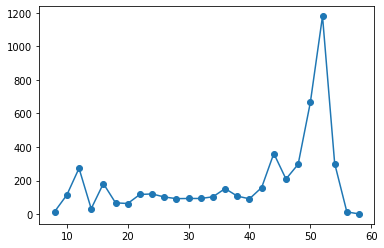

In [ ]:
def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))

final = generate_walk(number_qubits, iterator, sample_number)
graph(final)

Cool, right!? It's the mirror image of what we saw when the coin qubit was in the other state. Let's try one 
more thing, let's initialize our coin qubit in a "balanced" state, where interference doesn't bias our 
distribution towards only one side! We will set our initial state to:


$$|i\rangle \ = \ \frac{|\uparrow\rangle \ + \ i|\downarrow\rangle}{\sqrt{2}}$$


This is implemented by applying a Hadamard gate to $|\uparrow\rangle$, and then applying an $S$ gate to 
the qubit. When we simulate this with Cirq, we get:

Counter({12: 692, 52: 677, 50: 356, 14: 310, 16: 254, 54: 234, 48: 228, 10: 211, 44: 197, 20: 197, 18: 151, 42: 144, 46: 141, 22: 133, 26: 126, 30: 122, 36: 121, 38: 121, 40: 118, 28: 117, 32: 105, 24: 104, 34: 103, 8: 20, 56: 18})


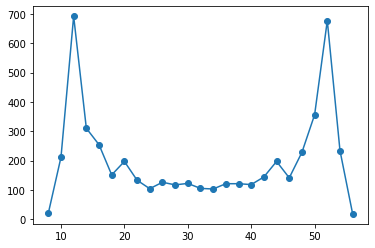

In [ ]:
def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))
    
    yield cirq.H.on(cirq.GridQubit(0, number_qubits))
    yield cirq.S.on(cirq.GridQubit(0, number_qubits))

final = generate_walk(number_qubits, iterator, sample_number)
graph(final)

So we get a probability distribution that is much more symmetric!

Random walks have applications in so many fields of scientific inquiry, ranging from biology, to 
computer science, to finance. I definitely think there are a lot of possible great extensions to this basic 
example of a QW and many more great projects that can be made by utilizing this interesting process!


## References

For more information about quantum random walks, see: https://arxiv.org/abs/quant-ph/0303081

For more information about applications of random walks, see: https://en.wikipedia.org/wiki/Random_walk#Applications